Datasets info:
- These test results are organized in such a way that when the number of mosquitos exceed 50, they are split into another record (another row in the dataset), such that the number of mosquitos are capped at 50. 

- "satellite traps" are set up near (usually within 6 blocks) an established trap to enhance surveillance efforts. Satellite traps are postfixed with letters.

- Records exist only when a particular species of mosquitos is found at a certain trap at a certain time. Date: date that the WNV test is performed

Some hints:
It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet.



In [111]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

import pyreadr
import myfunctions as f
import io

%matplotlib inline

In [112]:
# Loading data
df_train = pd.read_csv('../datasets/train.csv')
df_weather = pd.read_csv('../datasets/weather.csv')
df_spray = pd.read_csv('../datasets/spray.csv')

In [116]:
df_train.columns = [col.lower() for col in df_train.columns]
df_weather.columns = [col.lower() for col in df_weather.columns]
df_spray.columns = [col.lower() for col in df_spray.columns]

In [117]:
df_train.head()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [118]:
# Change Date type to datetime
df_train['date'] = pd.to_datetime(df_train['date'])
df_weather['date'] = pd.to_datetime(df_weather['date'])
df_spray['date'] = pd.to_datetime(df_spray['date'])

In [119]:
# Checking for datatypes
print(df_train.dtypes)
print(df_weather.dtypes)
print(df_spray.dtypes)

date                      datetime64[ns]
address                           object
species                           object
block                              int64
street                            object
trap                              object
addressnumberandstreet            object
latitude                         float64
longitude                        float64
addressaccuracy                    int64
nummosquitos                       int64
wnvpresent                         int64
dtype: object
station                 int64
date           datetime64[ns]
tmax                    int64
tmin                    int64
tavg                   object
depart                 object
dewpoint                int64
wetbulb                object
heat                   object
cool                   object
sunrise                object
sunset                 object
codesum                object
depth                  object
water1                 object
snowfall               object
preciptotal   

In [120]:
# Looking at number of rows
print(df_train.shape[0])
print(df_weather.shape[0])
print(df_spray.shape[0])

10506
2944
14835


In [121]:
# Checking for NA
print(df_train.isnull().sum().sum())
print(df_weather.isnull().sum().sum())
print(df_spray.isnull().sum().sum())

0
0
584


In [122]:
# Looking at rows with NA fro spray in detalies
print(df_spray.isnull().sum())
# Column 'Time' has 584 empty cells but it is not important for our analysis
# This cells are not ramdom missing
# the decision is to drop the column
df_spray.drop(columns='time',inplace=True)

date           0
time         584
latitude       0
longitude      0
dtype: int64


In [123]:
# Dropping duplicate rows
df_train.drop_duplicates(inplace=True)
df_weather.drop_duplicates(inplace=True)
df_spray.drop_duplicates(inplace=True)

In [124]:
# Checking number of rows again
print(df_train.shape[0])
print(df_weather.shape[0])
print(df_spray.shape[0])
# train dataset has 813 duplicated rows

9693
2944
14294


In [125]:
# Weather df has a lot of columns and some wrong values
df_weather.head()
# Depart
# Departure from normal. The difference between column 4 and the 30 year normal temperature 
# for this date. A minus (-) is number of degrees below normal.
# A zero (0) indicates that the average for that day was the Normal.

# DewPoint
# The dew point is the temperature the air needs to be cooled to (at constant pressure) 
# in order to achieve a relative humidity (RH) of 100%.

# WetBulb
# At 100% relative humidity, the wet-bulb temperature is equal to the air temperature 
# (dry-bulb temperature) and it is lower at lower humidity.

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,codesum,depth,water1,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [126]:
# Converting temperature from Fahrenheit to Celsius
def fahrenheit_to_celsius(df,column_names):
    '''
    Convert temperature from Fahrenheit to Celsius
    
    Takes:
    df - DataFrame
    column_names - (list of str) - names of columns for convertation
    
    Returns:
    df
    '''
    for name in column_names:
        df[name] = round((df[name]-32)*5/9,2)
    return df

In [127]:
# Replacing wrong data and converting dtype
df_weather['tavg'] = df_weather['tavg'].replace('M',-1).astype('int')
df_weather['depart'] = df_weather['depart'].replace('M',-1).astype('int')
df_weather['wetbulb'] = df_weather['wetbulb'].replace('M',-1).astype('int')

In [128]:
# Converting temperature from Fahrenheit to Celsius
fahrenheit_to_celsius(df_weather,['tmax','tmin','tavg','depart','dewpoint','wetbulb'])

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,codesum,depth,water1,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2007-05-01,28.33,10.00,19.44,-10.00,10.56,13.33,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,28.89,11.11,20.00,-18.33,10.56,13.89,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,15.00,5.56,10.56,-19.44,5.56,8.33,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,15.56,6.11,11.11,-18.33,5.56,8.33,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,18.89,7.78,13.33,-16.67,4.44,8.89,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,2,2014-10-29,9.44,4.44,7.22,-18.33,1.11,5.56,20,0,...,,M,M,M,0.00,29.42,30.07,8.5,29,9.0
2940,1,2014-10-30,10.56,0.00,5.56,-20.00,1.11,4.44,23,0,...,,0,M,0.0,0.00,29.34,30.09,5.1,24,5.5
2941,2,2014-10-30,11.67,2.78,7.22,-18.33,1.67,5.56,20,0,...,RA,M,M,M,T,29.41,30.10,5.9,23,6.5
2942,1,2014-10-31,8.33,0.56,4.44,-21.11,-3.89,0.56,25,0,...,RA SN,0,M,0.1,0.03,29.49,30.20,22.6,34,22.9


In [129]:
# Replacing wrong data and converting dtype
df_weather['heat'] = df_weather['heat'].replace('M',-100).astype('int')
df_weather['cool'] = df_weather['cool'].replace('M',-100).astype('int')
df_weather['sunrise'] = df_weather['sunrise'].replace('-',-100).astype('int')
df_weather['sunset'] = df_weather['sunset'].replace('-',-100).astype('int')
df_weather['preciptotal'] = df_weather['preciptotal'].replace('M',-100).replace('  T',-1).astype('float')
df_weather['sealevel'] = df_weather['sealevel'].replace('M',-100).astype('float')
df_weather['avgspeed'] = df_weather['avgspeed'].replace('M',-100).astype('float')
df_weather['stnpressure'] = df_weather['stnpressure'].replace('M',-100).astype('float')
df_weather['avgspeed'] = df_weather['avgspeed'].replace('M',-100).astype('float')

In [130]:
# Masking weather data by station
df_weather_st1 = df_weather[df_weather['station']==1]
df_weather_st2 = df_weather[df_weather['station']==2]

In [131]:
# Merging df_weather_st1 and df_weather_st2 in one rows
weather_df = pd.merge(df_weather_st1,df_weather_st2,on='date')

In [132]:
# Need to fill NA in station1 (x) with info from station2 (y)
# did not completed
null_index = weather_df.isnull().index
columns = [col for col in weather_df.columns if col !='date' if (col.split('_')[1]=='x')]
weather_df.loc[null_index, columns]

,station_x,tmax_x,tmin_x,tavg_x,depart_x,dewpoint_x,wetbulb_x,heat_x,cool_x,sunrise_x,...,codesum_x,depth_x,water1_x,snowfall_x,preciptotal_x,stnpressure_x,sealevel_x,resultspeed_x,resultdir_x,avgspeed_x
0,1,28.33,10.00,19.44,-10.00,10.56,13.33,0,2,448,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,1,15.00,5.56,10.56,-19.44,5.56,8.33,14,0,447,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
2,1,18.89,7.78,13.33,-16.67,4.44,8.89,9,0,446,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9
3,1,18.89,9.44,14.44,-15.56,5.00,10.00,7,0,444,...,RA,0,M,0.0,-1.00,29.31,30.05,10.4,8,10.8
4,1,18.89,11.67,15.56,-15.00,3.33,9.44,5,0,443,...,,0,M,0.0,-1.00,29.40,30.10,11.7,7,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,1,25.00,10.56,17.78,-8.89,10.56,14.44,1,0,618,...,,0,M,0.0,0.00,28.92,29.66,12.0,19,12.9
1468,1,20.00,7.22,13.89,-12.22,3.33,8.33,8,0,619,...,,0,M,0.0,-1.00,29.15,29.85,14.8,26,15.6
1469,1,9.44,2.22,6.11,-20.00,0.00,4.44,22,0,620,...,,0,M,0.0,0.00,29.36,30.06,9.5,29,9.9
1470,1,10.56,0.00,5.56,-20.00,1.11,4.44,23,0,622,...,,0,M,0.0,0.00,29.34,30.09,5.1,24,5.5


For deviding spray area and dates let's use DBSCAN to cluster the spots.

In [133]:
# Deviding data into parts
df_spray['day'] = df_spray['date'].map(lambda x: x.day)
df_spray['month'] = df_spray['date'].map(lambda x: x.month)
df_spray['year'] = df_spray['date'].map(lambda x: x.year)

In [134]:
# Choosing columns for clustering
X = df_spray[['day', 'month','year','latitude', 'longitude']]

In [135]:
# Standartizing data
ss = StandardScaler()
X_scaled = ss.fit_transform(X)
# Training DBSCAN for predicting 
dbs = DBSCAN(eps=0.1)
dbs.fit(X)

DBSCAN(algorithm='auto', eps=0.1, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [136]:
# Seeing labels (they should be 13)
dbs.labels_

array([ 0,  0,  0, ..., 12, 12, 12], dtype=int64)

In [137]:
# Adding labels to spray df
df_spray['labels'] = dbs.labels_

In [138]:
# Looking at result
clusteres_df = df_spray.groupby(['labels','date']).count()
clusteres_df.sort_values('date')

,,latitude,longitude,day,month,year
labels,date,,,,,
0,2011-08-29,95,95,95,95,95
1,2011-09-07,1573,1573,1573,1573,1573
2,2013-07-17,556,556,556,556,556
3,2013-07-17,1646,1646,1646,1646,1646
4,2013-07-25,1607,1607,1607,1607,1607
5,2013-08-08,1195,1195,1195,1195,1195
6,2013-08-15,2668,2668,2668,2668,2668
7,2013-08-16,141,141,141,141,141
8,2013-08-22,845,845,845,845,845


In [139]:
# Defining min and max latitudes and longitudes for each cluster
min_spray = max_spray = df_spray.groupby('labels')[['date','latitude','longitude']].min()
max_spray = max_spray = df_spray.groupby('labels')[['latitude','longitude']].max()

In [141]:
# Merging min and max df in one
min_max_spray = pd.merge(min_spray,max_spray,on='labels')
# Renaming columns to make them more understandable
min_max_spray.columns = ['date', 'latitude_min', 'longitude_min', 'latitude_max', 'longitude_max']

In [142]:
# Creating a new column is_spray and setting all cells as False
df_train['is_spray'] = False

In [143]:
# Setting time delta as 30 days. The spray lasts
# A typical mosquito treatment lasts about 30 days. 
# https://www.callnorthwest.com/2019/05/how-long-does-a-mosquito-treatment-last/
tdelta_min = dt.timedelta(days=0)
tdelta_max = dt.timedelta(days=30)
# Creating a new DataFrame
is_spray_df = pd.DataFrame(columns=df_train.columns)
# Looping through df with min,max latitudes and longitudes 
for i,spray in min_max_spray.iterrows():
    long_min = spray['longitude_min']
    long_max = spray['longitude_max']
    lat_min = spray['latitude_min']
    lat_max = spray['latitude_max']
# Looping through train df, checking is latitudes and longitudes lay between min and max
# and date is the same date or date +30 days of spraying 
    for j,row in df_train.iterrows():
        if ((lat_min <= row['latitude'] <= lat_max) &
            (long_min <= row['longitude'] <= long_max) &
            (tdelta_min < (row['date']-spray['date']) <=tdelta_max)):
            row['is_spray'] = True
            is_spray_df = is_spray_df.append(row)

In [144]:
# Joining new df with spray info with train data
df_train_spray = pd.concat([df_train,is_spray_df])

In [145]:
# Dropping rows which were change in is_spray to True
df_train_spray = df_train_spray.drop_duplicates(subset=['date', 'address', 'species', 
        'block', 'street', 'trap','addressnumberandstreet', 'latitude', 'longitude', 
        'addressaccuracy','nummosquitos', 'wnvpresent'],keep='last')

In [146]:
# Checking number of rows in train which were sprayed
df_train_spray['is_spray'].value_counts()

False    9468
True      225
Name: is_spray, dtype: int64

In [147]:
# Merging weather and train df
main_df = pd.merge(df_train_spray,weather_df,on='date')
main_df.head()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,...,codesum_y,depth_y,water1_y,snowfall_y,preciptotal_y,stnpressure_y,sealevel_y,resultspeed_y,resultdir_y,avgspeed_y
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,BR HZ,M,M,M,0.0,29.44,30.09,5.8,16,7.4
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,BR HZ,M,M,M,0.0,29.44,30.09,5.8,16,7.4
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,...,BR HZ,M,M,M,0.0,29.44,30.09,5.8,16,7.4
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,BR HZ,M,M,M,0.0,29.44,30.09,5.8,16,7.4
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,BR HZ,M,M,M,0.0,29.44,30.09,5.8,16,7.4


In [149]:
# Creating new column with years
main_df['year'] = main_df.date.map(lambda x: x.year)

In [150]:
main_df['nummosquitos'] = main_df.loc[:,'nummosquitos'].astype('int')
main_df['wnvpresent'] = main_df['wnvpresent'].astype('int')

In [151]:
main_df['is_spray'] = main_df['is_spray'].map({True:1,False:0})

## Exploratory Data Analysis

In [153]:
main_df['wnvpresent'].value_counts(normalize=True)

0    0.948107
1    0.051893
Name: wnvpresent, dtype: float64

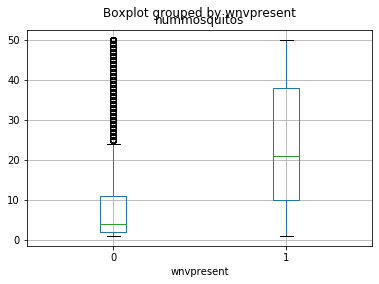

In [154]:
# Number of cought mosquitos by presence of virus
df_train.boxplot(by='wnvpresent',column='nummosquitos');
# Virus is present if number of mosquitos is high

# These test results are organized in such a way that when the number of mosquitos exceed 50, 
# they are split into another record (another row in the dataset), 
# such that the number of mosquitos are capped at 50.

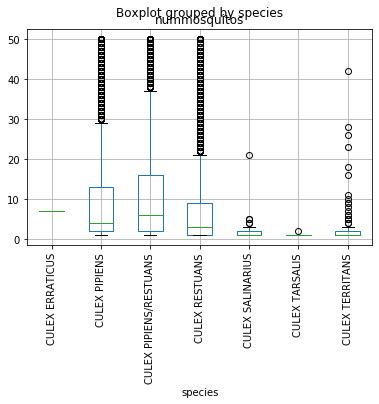

In [155]:
# Number of misquitos by species of mosquitos
df_train.boxplot(by='species',column='nummosquitos',rot=90);
# 3 species of mosquitos caught much frequantly than others

# Records exist only when a particular species of mosquitos is found at a certain trap 
# at a certain time. Date: date that the WNV test is performed

In [156]:
# NumMosquitos and WnvPresent by species
df_train.groupby('species')[['nummosquitos','wnvpresent']].sum()
# 3 species cought much frequantly and they contain virus
# ? does other species are rare in the area
# ? does it mean that other species can have the virus but due to their rareness we don't see it

,nummosquitos,wnvpresent
species,,
CULEX ERRATICUS,7,0
CULEX PIPIENS,23238,208
CULEX PIPIENS/RESTUANS,53691,246
CULEX RESTUANS,21376,49
CULEX SALINARIUS,144,0
CULEX TARSALIS,7,0
CULEX TERRITANS,508,0


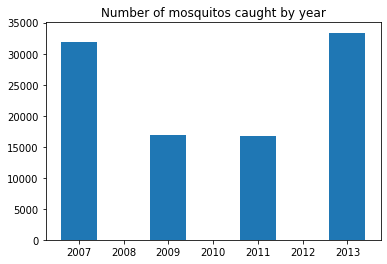

In [157]:
year_numb = main_df.groupby('year')['nummosquitos'].sum()
plt.bar(year_numb.index,year_numb.values)
plt.title('Number of mosquitos caught by year');

<Figure size 1008x1152 with 0 Axes>

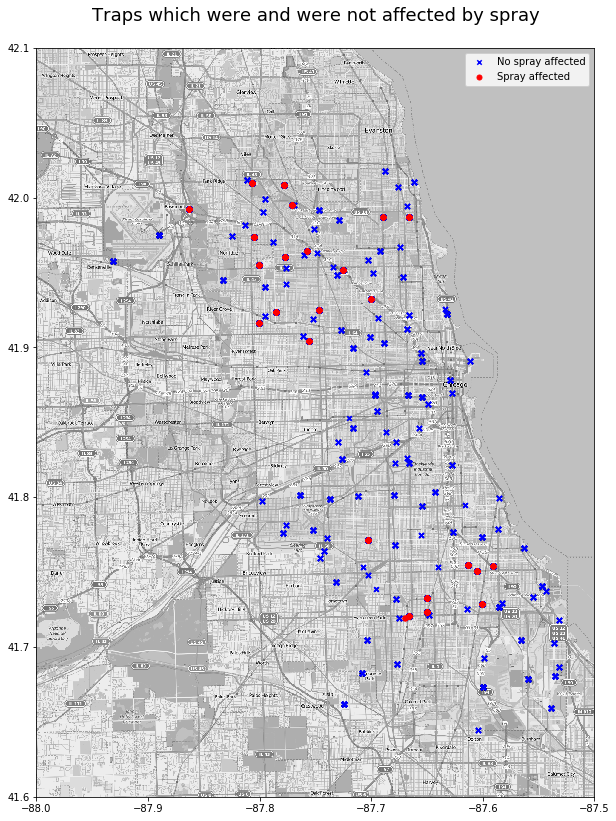

In [158]:
spray_traps = main_df[main_df['is_spray']==True]
spray_no_traps = main_df[main_df['is_spray']==False]
fig = plt.figure(figsize=(14,16))

origin = [41.6, -88.0]              # lat/long of origin (lower left corner)
upperRight = [42.1, -87.5]          # lat/long of upper right corner
# mapdata = np.loadtxt("./data/mapdata_copyright_openstreetmap_contributors.txt")

lats_spray = spray_traps['latitude']
longs_spray = spray_traps['longitude']
lats_no_spray = spray_no_traps['latitude']
longs_no_spray = spray_no_traps['longitude']

# generate plot
# plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=[origin[1], upperRight[1], origin[0], upperRight[0]])
f.gen_map()
plt.scatter(x=longs_no_spray, y=lats_no_spray, c='b', s=20, marker='x',label='No spray affected')
plt.scatter(x=longs_spray, y=lats_spray, c='r', s=25,label='Spray affected')
plt.title('Traps which were and were not affected by spray\n',fontsize=18)
plt.legend()
plt.show()

<Figure size 1008x1152 with 0 Axes>

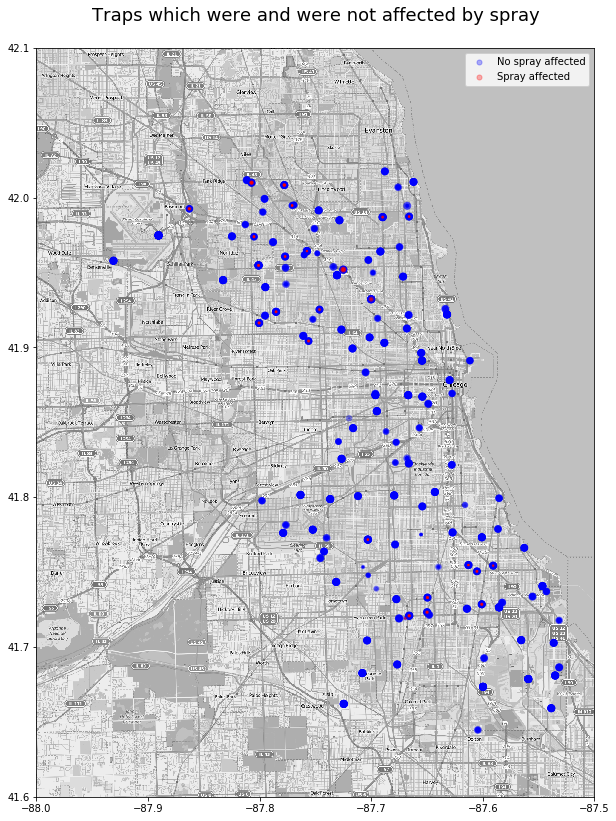

In [159]:
spray_traps = main_df[main_df['is_spray']==True]
spray_no_traps = main_df[main_df['is_spray']==False]
fig = plt.figure(figsize=(14,16))

origin = [41.6, -88.0]              # lat/long of origin (lower left corner)
upperRight = [42.1, -87.5]          # lat/long of upper right corner
# mapdata = np.loadtxt("./data/mapdata_copyright_openstreetmap_contributors.txt")

lats_spray = spray_traps['latitude']
longs_spray = spray_traps['longitude']
lats_no_spray = spray_no_traps['latitude']
longs_no_spray = spray_no_traps['longitude']
size_num_mosq_spray = spray_traps['nummosquitos']
size_num_mosq_no_spray = spray_no_traps['nummosquitos']
# generate plot
# plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=[origin[1], upperRight[1], origin[0], upperRight[0]])
f.gen_map()
plt.scatter(x=longs_no_spray, y=lats_no_spray, c='b', s=size_num_mosq_spray, label='No spray affected',alpha=0.3)
plt.scatter(x=longs_spray, y=lats_spray, c='r', s=size_num_mosq_no_spray,label='Spray affected',alpha=0.3)
plt.title('Traps which were and were not affected by spray\n',fontsize=18)
plt.legend()
plt.show()

In [160]:
# Deviding main df to spray/no spray data
spray_traps = main_df[main_df['is_spray']==True]
spray_no_traps = main_df[main_df['is_spray']==False]

In [162]:
# Number of mosq caught with spray applied
spray_traps[['wnvpresent','nummosquitos']].describe().T

,count,mean,std,min,25%,50%,75%,max
wnvpresent,225.0,0.115556,0.320404,0.0,0.0,0.0,0.0,1.0
nummosquitos,225.0,16.017778,15.041895,1.0,4.0,10.0,25.0,50.0


In [163]:
# Number of mosq caught without spray applied
spray_no_traps[['wnvpresent','nummosquitos']].describe().T
# We see that number of mosquitos large whrn spray was applied, the resion can be 
# the seasonal spraying - only those days when number of mosquitos is high
# let's investigate it

,count,mean,std,min,25%,50%,75%,max
wnvpresent,9468.0,0.05038,0.218740,0.0,0.0,0.0,0.0,1.0
nummosquitos,9468.0,10.07256,13.059658,1.0,2.0,4.0,13.0,50.0


In [164]:
# Let's compare number of mosq in places where spray was present 
# and was not present in the same dates.

# For this no spray df should be filtered by days
# getting unique dates of spray
days = np.unique(spray_traps['date'].values)
# creating a new df
spray_other_location = pd.DataFrame()
# iter though days and no spray df
for day in days:
    for i,row in spray_no_traps.iterrows():
#         checking if date is the same
        if row['date'] == day:
#         if True - adding to new df
            spray_other_location = spray_other_location.append(row)

In [165]:
# cheking new df
spray_other_location.head(2)

,address,addressaccuracy,addressnumberandstreet,avgspeed_x,avgspeed_y,block,codesum_x,codesum_y,cool_x,cool_y,...,tmax_y,tmin_x,tmin_y,trap,water1_x,water1_y,wetbulb_x,wetbulb_y,wnvpresent,year
6945,"4100 North Oak Park Avenue, Chicago, IL 60634,...",9.0,"4100 N OAK PARK AVE, Chicago, IL",10.9,9.3,41.0,,,10.0,10.0,...,30.0,17.78,17.78,T002,M,M,18.33,18.33,0.0,2011.0
6946,"4100 North Oak Park Avenue, Chicago, IL 60634,...",9.0,"4100 N OAK PARK AVE, Chicago, IL",10.9,9.3,41.0,,,10.0,10.0,...,30.0,17.78,17.78,T002,M,M,18.33,18.33,0.0,2011.0


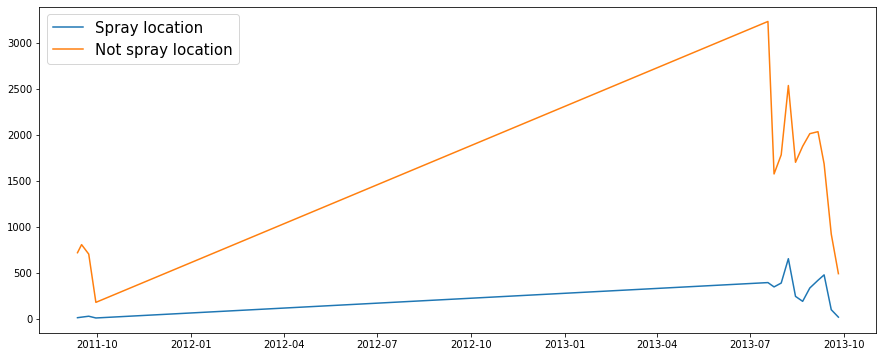

In [167]:
# let's visualize number of mosq in dates when spray were applied in spray and no spray locations
plt.figure(figsize=(15,6))
date_n_mosq_spr = spray_traps.groupby(['date'])['nummosquitos'].sum()
date_n_mosq_no_spr = spray_other_location.groupby(['date'])['nummosquitos'].sum()
plt.plot(date_n_mosq_spr.index,date_n_mosq_spr.values,label='Spray location')
plt.plot(date_n_mosq_no_spr.index,date_n_mosq_no_spr.values,label='Not spray location')
plt.legend(prop={'size': 15});

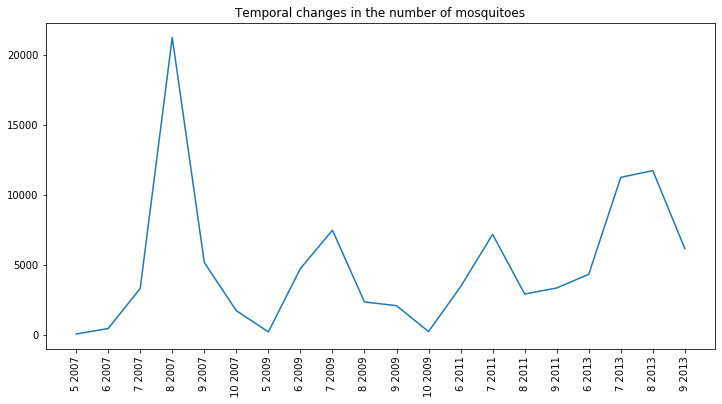

In [243]:
# Visualisation of temporal trand of number of mosquitoes 
main_df['month'] = main_df['date'].map(lambda x: x.month)
num_mosq_month = main_df.groupby(['year','month'])['nummosquitos'].sum().reset_index(level=[0,1])
plt.figure(figsize=(12,6))
plt.plot(num_mosq_month['nummosquitos'])
plt.xticks(range(len(num_mosq_month)),
labels=list(num_mosq_month['month'].astype('str')+' '+num_mosq_month['year'].astype('str')),
          rotation='vertical')
plt.title('Temporal changes in the number of mosquitoes');

From the linegraph it can be seen that the train dataset contain information only about 5th,6th,7th,8th,9th and 10th months of 2007,2009,2011 and 2013 years.

The biggest numbers of mosquitoes are in 7th and 8th each year.

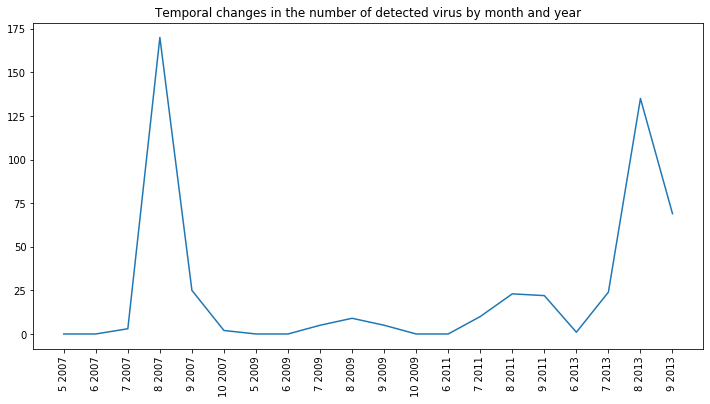

In [246]:
num_mosq_month = main_df.groupby(['year','month'])['wnvpresent'].sum().reset_index(level=[0,1])
plt.figure(figsize=(12,6))
plt.plot(num_mosq_month['wnvpresent'])
plt.xticks(range(len(num_mosq_month)),
labels=list(num_mosq_month['month'].astype('str')+' '+num_mosq_month['year'].astype('str')),
          rotation='vertical')
plt.title('Temporal changes in the number of detected virus by month and year');

The linegraph illustrate that high number of virus was datacted in month 8.

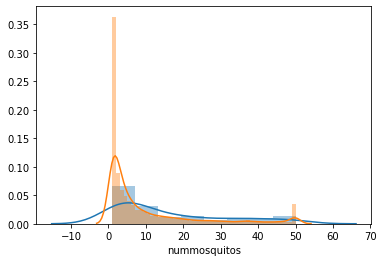

In [168]:
# distribution number of mosquitos with\without spray applied
sns.distplot(spray_traps['nummosquitos'])
sns.distplot(spray_no_traps['nummosquitos'])

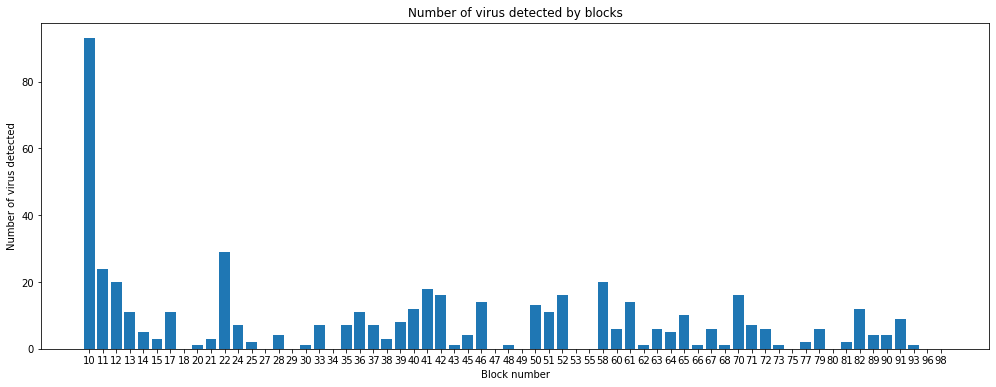

In [286]:
plt.figure(figsize=(17,6))
plt.bar(range(len(main_df['block'].unique())), main_df.groupby('block')['wnvpresent'].sum())
plt.xlabel('Block number')
plt.ylabel('Number of virus detected')
plt.title('Number of virus detected by blocks')
plt.xticks(range(len(main_df['block'].unique())),labels=sorted(main_df['block'].unique()));

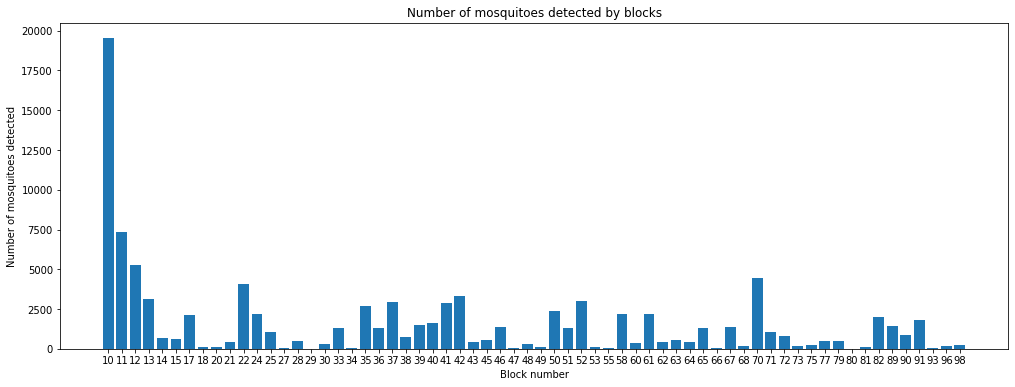

In [285]:
plt.figure(figsize=(17,6))
plt.bar(range(len(main_df['block'].unique())), main_df.groupby('block')['nummosquitos'].sum())
plt.xlabel('Block number')
plt.ylabel('Number of mosquitoes detected')
plt.title('Number of mosquitoes detected by blocks')
plt.xticks(range(len(main_df['block'].unique())),labels=sorted(main_df['block'].unique()));

It can be seen that 10th block have the anomaly high number of virus detected and number of mosquitoes.

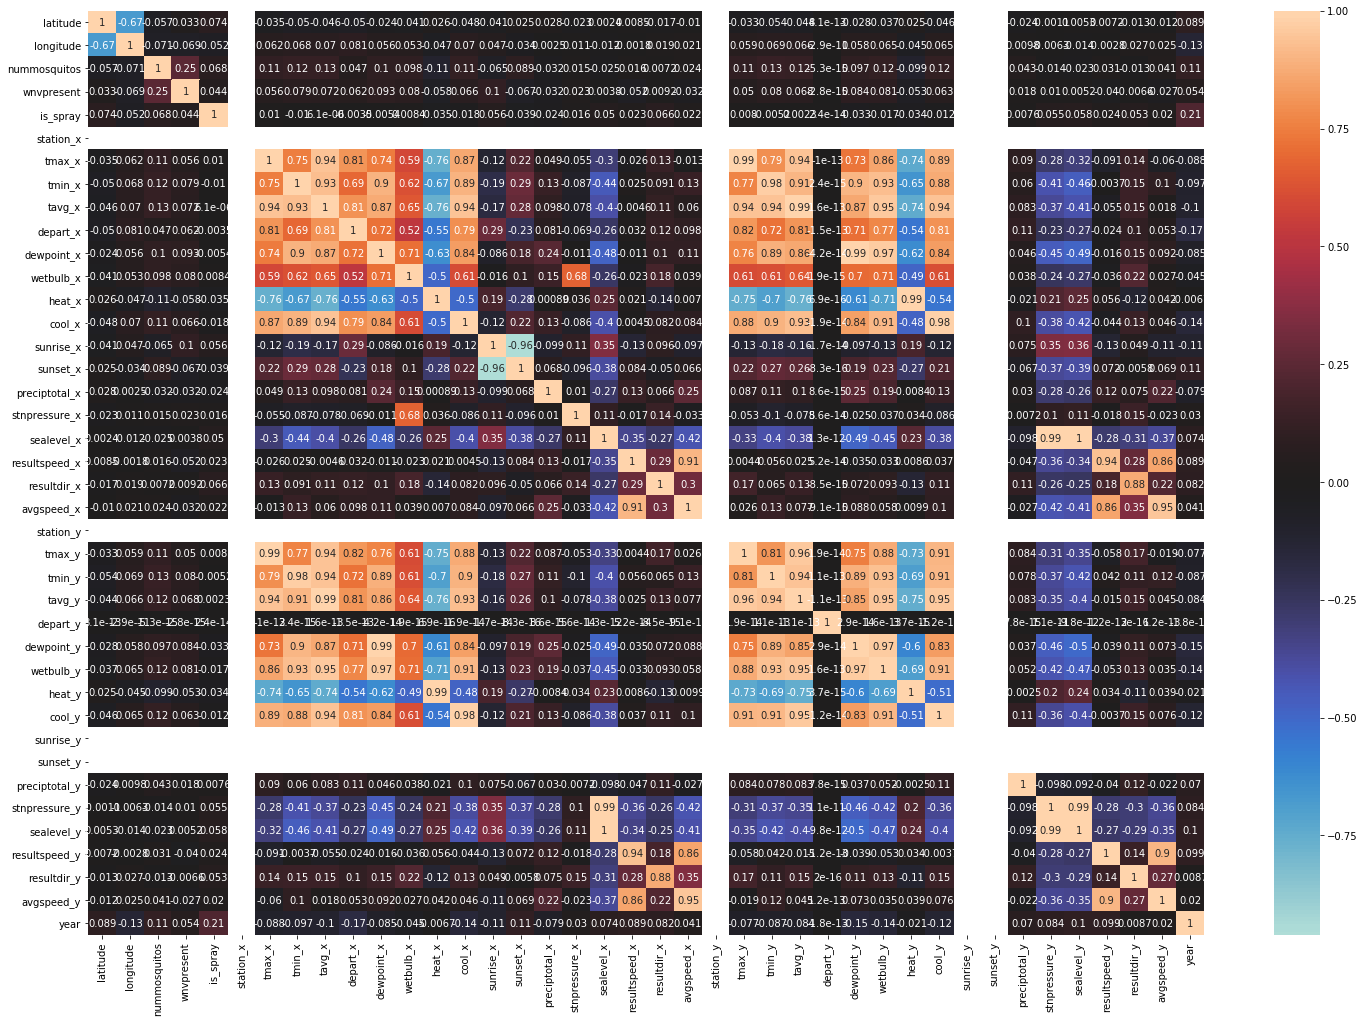

In [176]:
plt.figure(figsize=(25,17))
sns.heatmap(main_df.corr(),annot=True,center=0);

In [ ]:
# don't see any correlation between num of mosq/VirusPresent and other columns

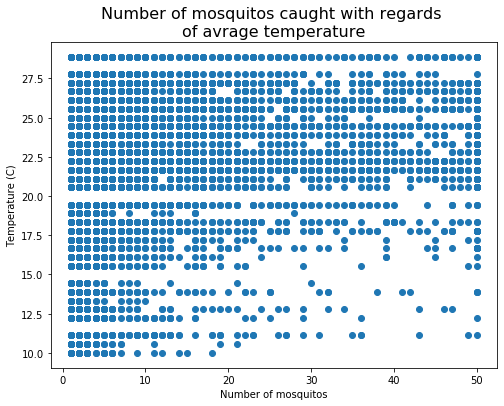

In [170]:
fig=plt.figure(figsize=(8,6))
plt.scatter(main_df['nummosquitos'],main_df['tavg_x'])
plt.title('Number of mosquitos caught with regards \nof avrage temperature',fontsize=16)
plt.xlabel('Number of mosquitos')
plt.ylabel('Temperature (C)');

In [172]:
# Now let's compare number of mosq there spray and no spray with same dates
# Number of mosq caught with spray applied
grouped_spray = spray_traps.groupby(['date','trap'])[['wnvpresent','nummosquitos']].sum()
grouped_spray[['wnvpresent','nummosquitos']].describe().T

,count,mean,std,min,25%,50%,75%,max
wnvpresent,109.0,0.238532,0.469418,0.0,0.0,0.0,0.0,2.0
nummosquitos,109.0,33.064220,40.344414,1.0,9.0,17.0,42.0,217.0


In [173]:
# Number of mosq caught with spray not applied
grouped_no_spray = spray_other_location.groupby(['date','trap'])[['wnvpresent','nummosquitos']].sum()
grouped_no_spray[['wnvpresent','nummosquitos']].describe().T

,count,mean,std,min,25%,50%,75%,max
wnvpresent,894.0,0.234899,0.681438,0.0,0.0,0.0,0.0,10.0
nummosquitos,894.0,24.878076,44.630067,1.0,4.0,10.0,28.0,500.0


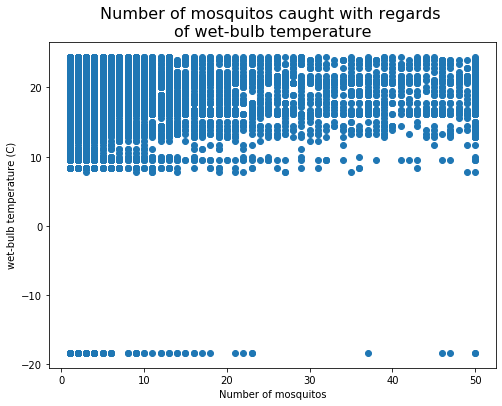

In [174]:
# Plotting distribution the number of mosquitoes with regards to wet bulb from station 1
fig=plt.figure(figsize=(8,6))
plt.scatter(main_df['nummosquitos'],main_df['wetbulb_x'])
plt.title('Number of mosquitos caught with regards \nof wet-bulb temperature',fontsize=16)
plt.xlabel('Number of mosquitos')
plt.ylabel('wet-bulb temperature (C)');

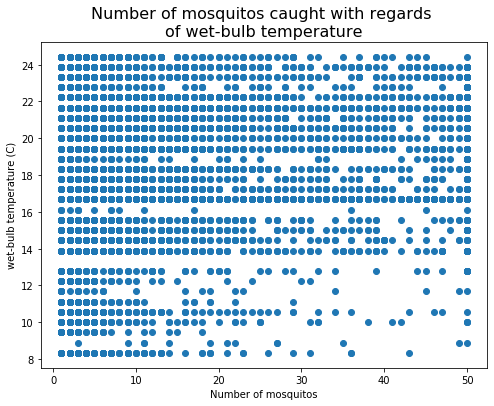

In [175]:
# Plotting the same graph but taken information of wet bulb from station 2
fig=plt.figure(figsize=(8,6))
plt.scatter(main_df['nummosquitos'],main_df['wetbulb_y'])
plt.title('Number of mosquitos caught with regards \nof wet-bulb temperature',fontsize=16)
plt.xlabel('Number of mosquitos')
plt.ylabel('wet-bulb temperature (C)');
# The scatterplots showen that the information from station 1 is incomplete,
# let's explore the information from station 1 and station 2

In [ ]:
# Looking for difference in station1 and station2 data

In [215]:
def scatter(column_list,df=main_df):
    '''
    Plot station 1 against station 2
    '''
    nrows = int(np.ceil(len(column_list)/2))
    fig,ax=plt.subplots(nrows=nrows,ncols=2,figsize=(20,50))
    for i,name in enumerate(column_list):
        x = df[name + '_x']
        y = df[name +'_y']
        if i <=nrows-1:
            c=0
            a = i
        else:
            c=1
            a = i - nrows

        ax[a,c].scatter(x,y)
        ax[a,c].set_title(name,fontsize=15)
        plt.tight_layout(pad=0.4, w_pad=2, h_pad=2)
        
def boxplots(column_list,df=main_df):
    '''
    Plot boxplot of all columns of station 1,station 2
    '''
    nrows = int(np.ceil(len(column_list)/4))
    fig,ax=plt.subplots(nrows=nrows,ncols=4,figsize=(20,50))
    for i,name in enumerate(column_list):
        x = df[name]
        if i <=nrows-1:
            c=0
            a=i
        elif i <=nrows*2-1:
            c=1
            a=i - nrows
        elif i <=nrows*3-1:
            c=2
            a=i - nrows*2
        else:
            c=3
            a=i - nrows*3

        ax[a,c].boxplot(x=x)
        ax[a,c].set_title(name,fontsize=15)
        plt.tight_layout(pad=0.4, w_pad=2, h_pad=2)

In [179]:
column_names = [name.split('_')[0] for name in ['station_x', 'tmax_x',
       'tmin_x', 'tavg_x', 'depart_x', 'dewpoint_x', 'wetbulb_x', 'heat_x',
       'cool_x', 'sunrise_x', 'sunset_x', 'codesum_x', 'depth_x', 'water1_x',
       'snowfall_x', 'preciptotal_x', 'stnpressure_x', 'sealevel_x',
       'resultspeed_x', 'resultdir_x', 'avgspeed_x', 'station_y', 'tmax_y',
       'tmin_y', 'tavg_y', 'depart_y', 'dewpoint_y', 'wetbulb_y', 'heat_y',
       'cool_y', 'sunrise_y', 'sunset_y', 'codesum_y', 'depth_y', 'water1_y',
       'snowfall_y', 'preciptotal_y', 'stnpressure_y', 'sealevel_y',
       'resultspeed_y', 'resultdir_y', 'avgspeed_y']]
column_names = list(set(column_names))

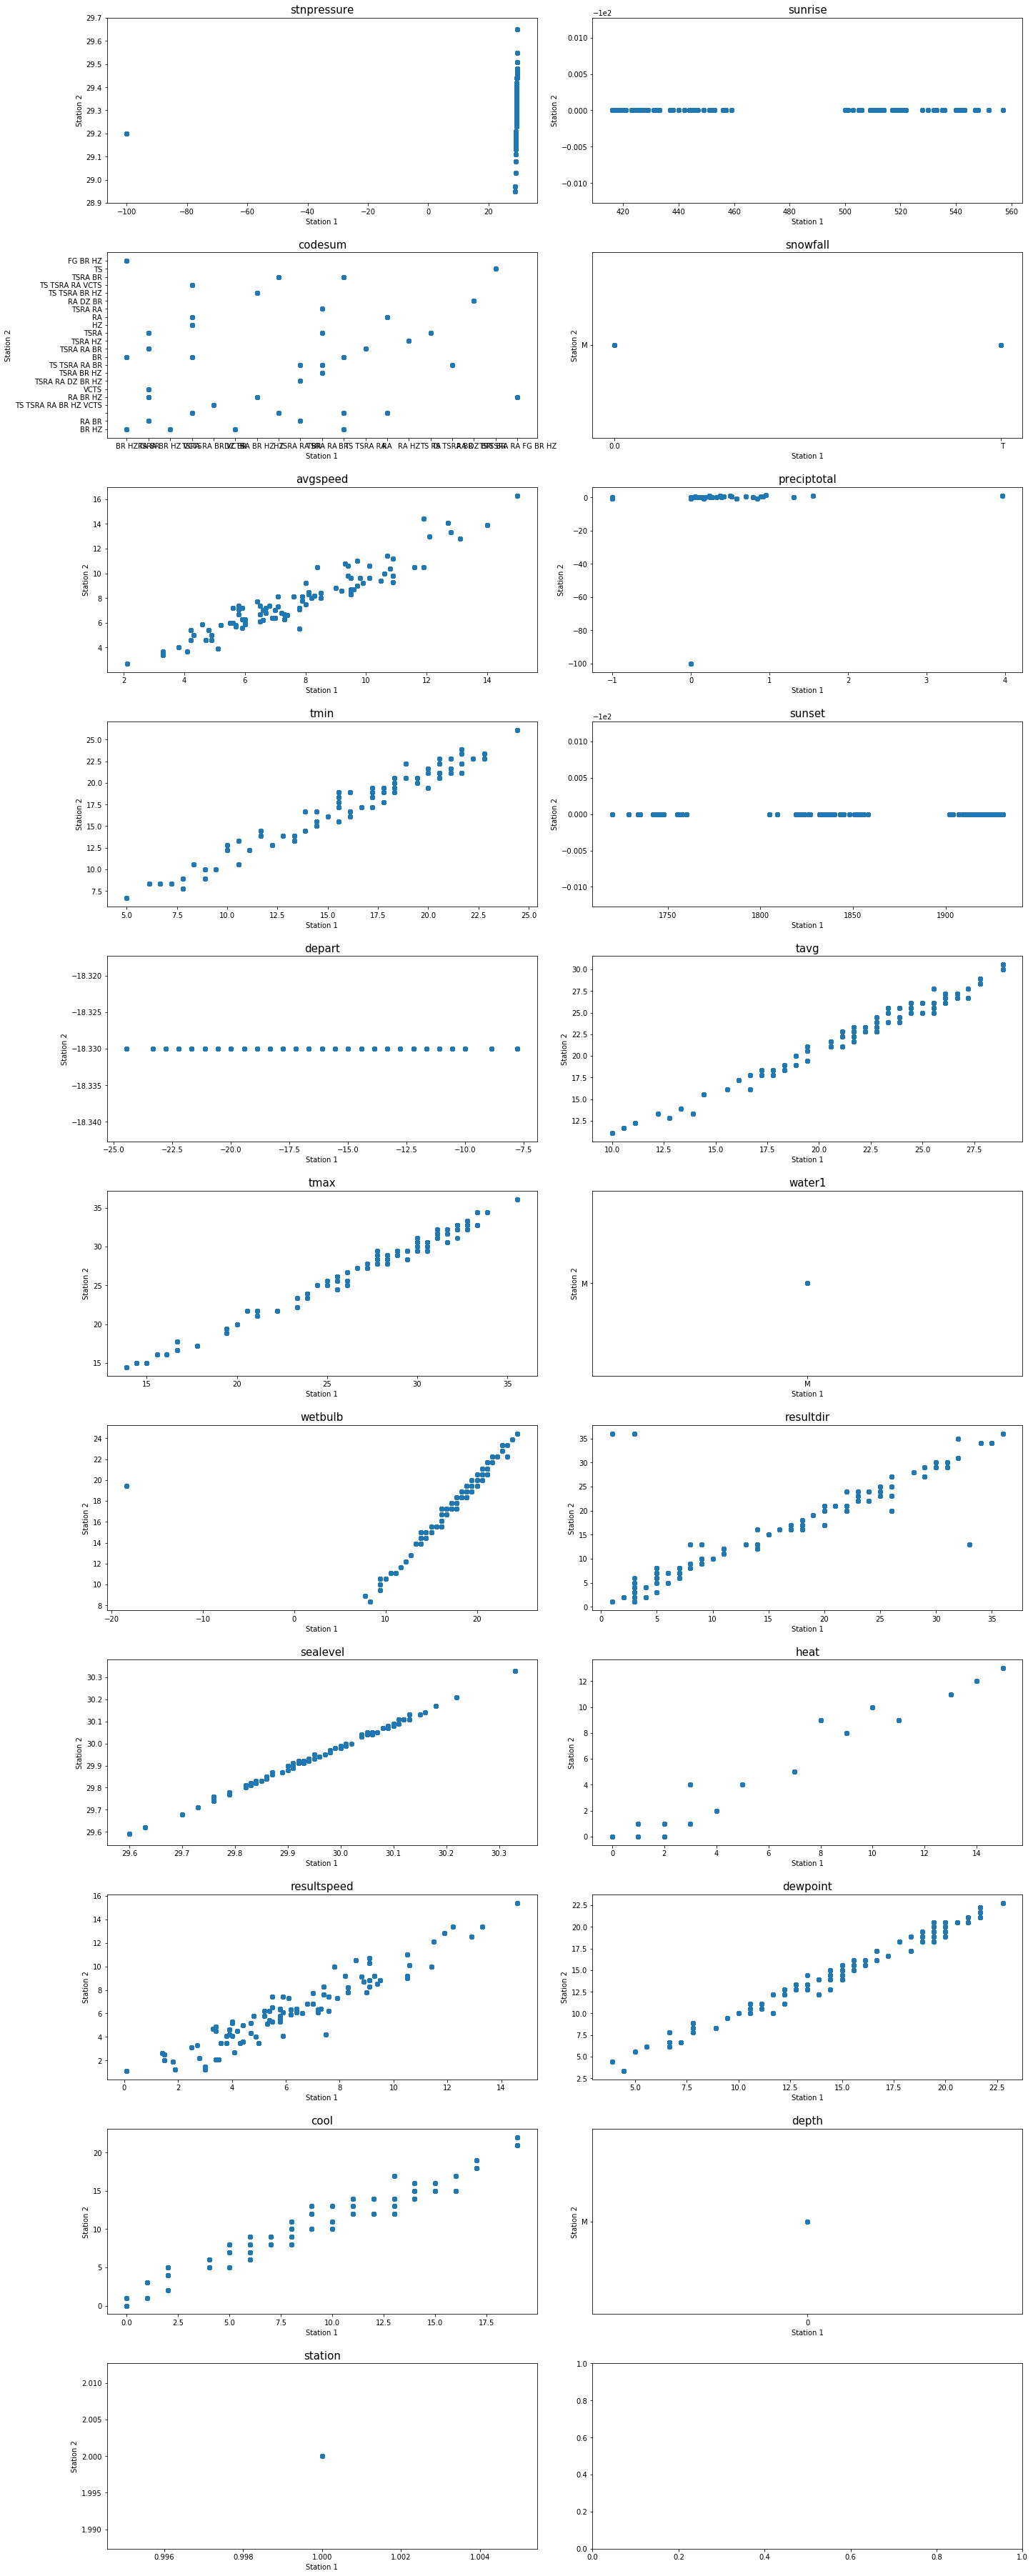

In [180]:
scatter(column_names)

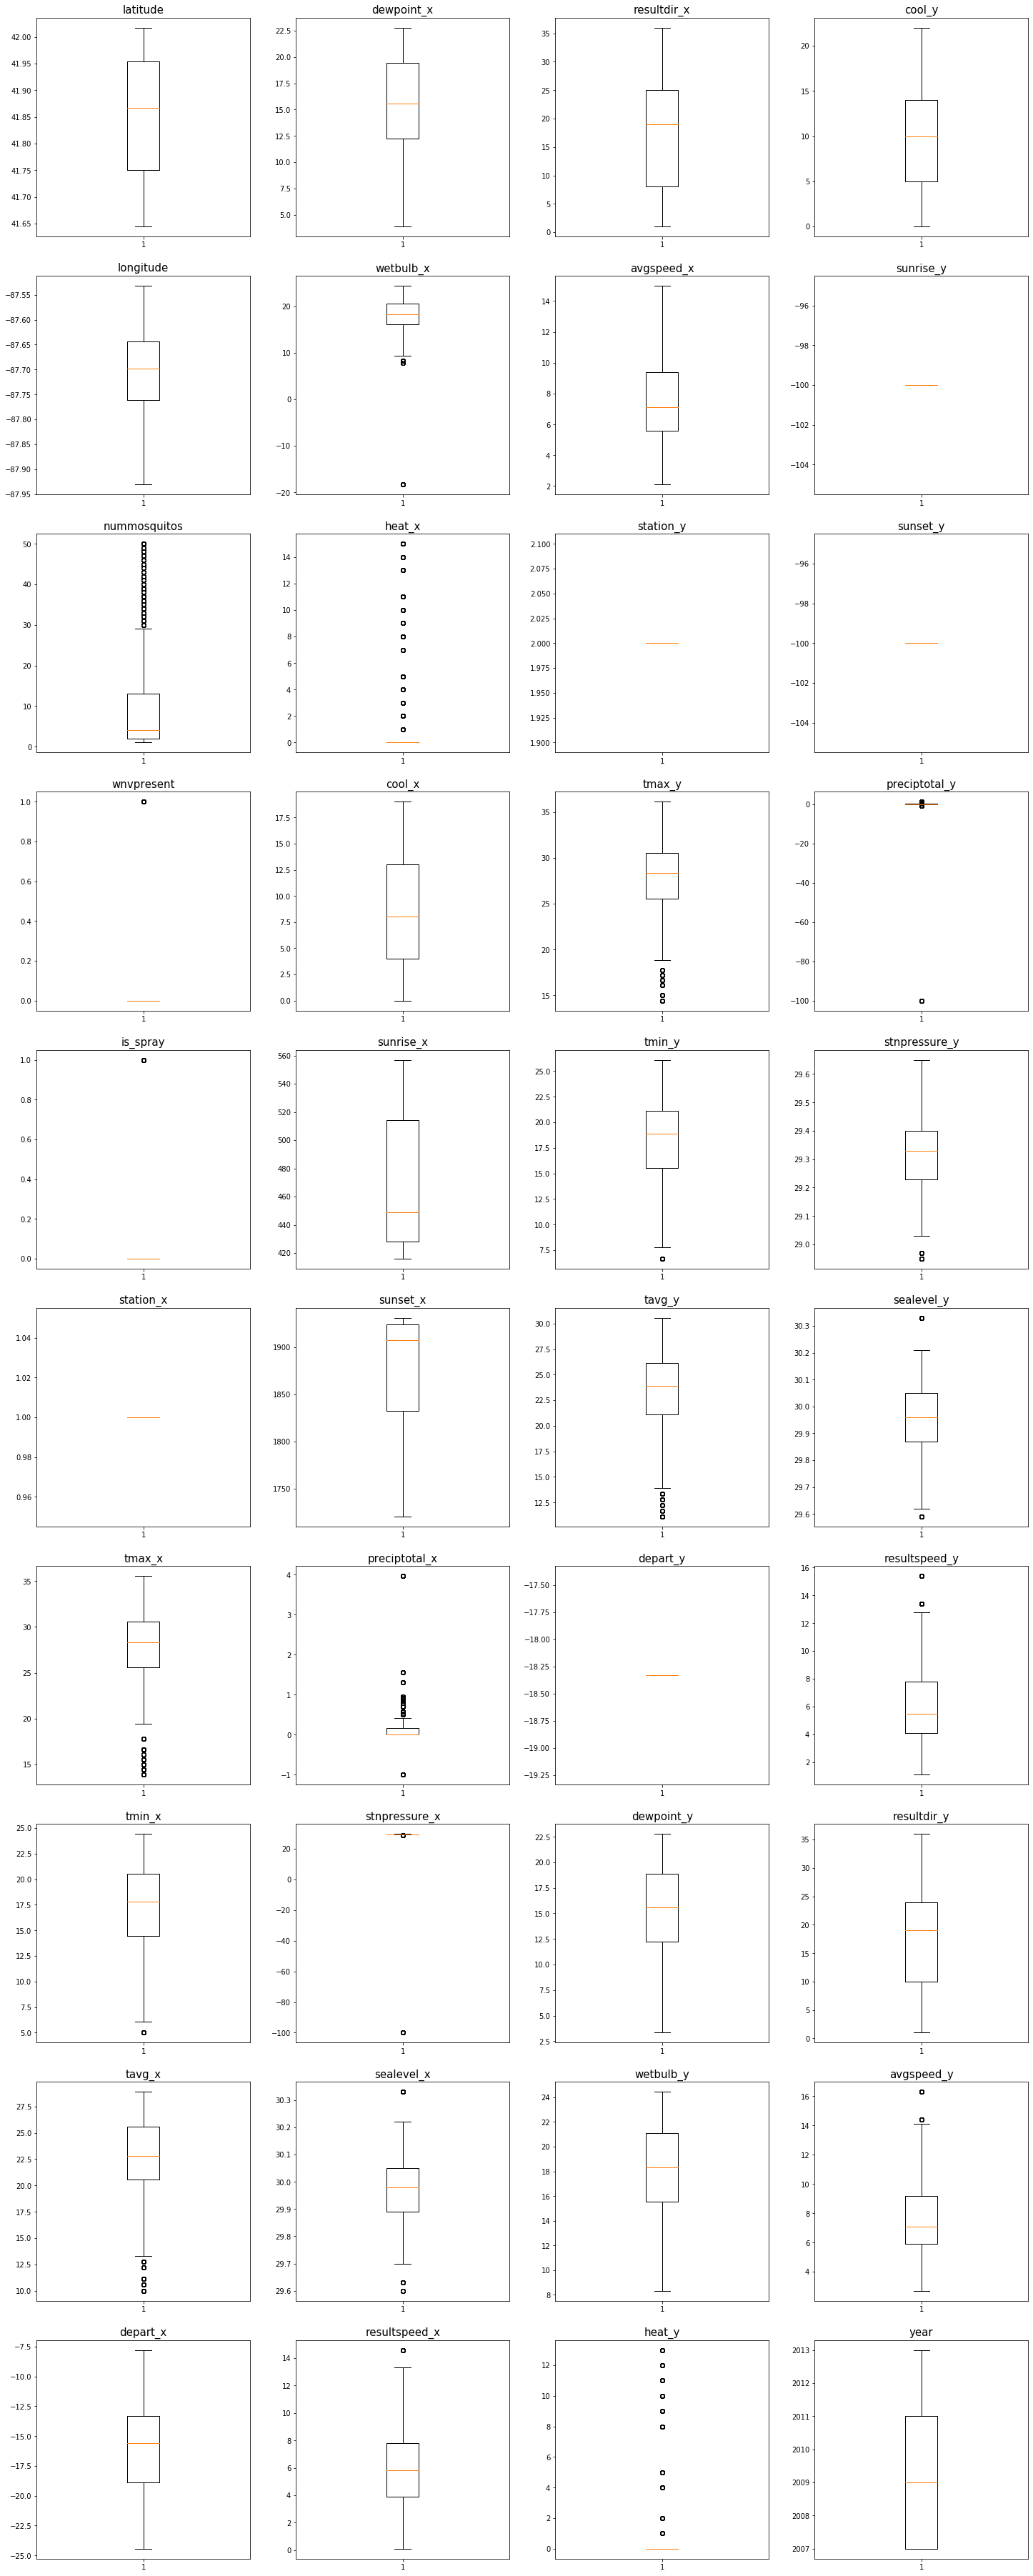

In [216]:
not_str_df = main_df.select_dtypes(exclude=['object','datetime'])
boxplots(not_str_df.columns)

As two bunch of graphs above have shown, weather data from station 1 and station 2 is very similar.

The scatterplots showed that despite linear relationships between the weather information, there are some outliers or anomalies. 
The boxplots illustrated that those anomalies and outliers were recorded on station 1. The decision is to fill all NA of station 2 with info from station 1 and drow all columns from station 1.